In [2]:
import numpy as np
import pandas as pd
import sklearn.linear_model as linear
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn import svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sb
import warnings
import missingno as msn
warnings.filterwarnings('ignore')

Here we import the datasets.

dhs_df is the dataset Mike put together. (Old one from June 27)
dhs_ungrouped_df is the ungrouped version.

In [3]:
dhs_df = pd.read_csv("datasets/DHS_Data_By_Cell_with_Regression_Dat_AggregatedFoodGroups_27June2019.csv")

# For merging with complete dataset later
dhs_ungrouped_df = pd.read_csv("datasets/DHS_Data_By_Cell_with_Regression_Dat_27June2019.csv")

In [4]:
# See what the dataset look like. 
dhs_df.head()

,Cell_Order,fruits,Num_Households_Responded_fruits,vegetables,Num_Households_Responded_vegetables,dairy,Num_Households_Responded_dairy,eggs,Num_Households_Responded_eggs,meat_fish,...,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Fruits - Excluding Wine,Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,Cons_kg.yr Starchy Roots,Cons_kg.yr Sugar & Sweeteners,Cons_kg.yr Vegetables
0,2158169,0.179487,13.0,0.494505,13.0,0.159341,13.0,0.346520,13.0,0.480220,...,17.324,15.084,52.856,51.040,156.888,2.434,1.542,135.794,47.558,154.956
1,2158170,0.227965,16.0,0.113839,16.0,0.353051,16.0,0.046875,16.0,0.280072,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
2,2158171,0.166450,11.0,0.282359,11.0,0.319772,11.0,0.106585,11.0,0.136905,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
3,2158173,0.321429,7.0,0.054945,7.0,0.877060,7.0,0.269231,7.0,0.153846,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622
4,2158174,0.207953,14.0,0.199923,14.0,0.190168,14.0,0.178890,14.0,0.086466,...,9.950,13.060,48.086,36.246,153.394,2.108,1.076,56.794,24.022,97.622


### Preparing Dataset

Here we add more country level variables by merging the dhs_df with other datasets.  

In [5]:
# Read in FAO production daata, and our socio economic dataset. 
production_df = pd.read_csv("datasets/production_avg_2011_2013.csv")
socio_economic_df = pd.read_csv("datasets/master.csv")

In [6]:
# Read in environmental variables 
# This dataset does not have ISO3C GONNA add that. 
env_df = pd.read_excel("datasets/analysis4_environment_finaldata.xlsx")

In [7]:
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2,country_name_to_country_alpha3,country_alpha3_to_country_alpha2

In [8]:
def convert_to_iso3c(countries):
    """
    This function tries to rechieve an alpha 3 Country Code based on the name. 
    """
    country_codes = []
    for country in countries:
        try:
            country_code = country_name_to_country_alpha3(country)
            country_codes.append(country_code)
        except KeyError:
            print(country)
            country_codes.append(country)
    return country_codes

In [9]:
country_codes = convert_to_iso3c(env_df["Country"])


Bolivia (Plurinational State of)
CÃ´te d'Ivoire
Channel Islands
China, Hong Kong SAR
China, Macao SAR
China, mainland
China, Taiwan Province of
Eswatini
Holy See
Iran (Islamic Republic of)
Micronesia (Federated States of)
Netherlands Antilles (former)
North Macedonia
Pitcairn Islands
RÃ©union
Republic of Korea
Sudan (former)
Svalbard and Jan Mayen Islands
Venezuela (Bolivarian Republic of)
Wallis and Futuna Islands


In [10]:
manual_country_code_dict = {"Bolivia (Plurinational State of)":"BOL"
                            ,"Channel Islands":""
                         ,"China, Hong Kong SAR":"HKG"
                         ,"China, mainland":"CHN"
                         ,"China, Macao SAR":"MAC"
                         ,"China, Taiwan Province of":"TWN"
                         ,"Holy See":"VAT"
                         ,"CÃƒÂ´te d'Ivoire":"CIV"
                            ,"CÃ´te d'Ivoire":"CIV"
                        ,"Pitcairn Islands":"PCN"
                        ,"Iran (Islamic Republic of)":"IRN"
                        ,"Republic of Korea":"KOR"
                        ,"Eswatini":"SWZ"
                        ,"RÃ©union":"REU"
                        ,"Netherlands Antilles (former)":"ANT"
                        ,"Svalbard and Jan Mayen Islands":"SJM"
                        ,"Sudan (former)":"SDN"
                        ,"North Macedonia":"MKD"
                        ,"Republic of North Macedonia":"MKD"
                        ,"Timor-Leste":"TLS"
                        ,"Wallis and Futuna Islands":"WLF"
                        ,"Venezuela (Bolivarian Republic of)":"VEN"}


In [11]:
# principalDf.to_csv("test.csv")
env_df["ISO3C"] = country_codes
env_df["ISO3C"] = env_df["ISO3C"].replace(manual_country_code_dict)

In [12]:
# Here we merge all the datasets together 

dhs_merged_df = dhs_df.merge(socio_economic_df, how="left", left_on= "ISO3C", right_on = "Country Code")
dhs_merged_env_df = dhs_merged_df.merge(env_df, how="left", on= "ISO3C")
dhs_ml_df = dhs_merged_env_df.merge(production_df,how = "left",left_on = "ISO3C",right_on = "Code")

In [13]:
# Let's look at all the columns we have now.
dhs_ml_df.columns 

Index(['Cell_Order', 'fruits', 'Num_Households_Responded_fruits', 'vegetables',
       'Num_Households_Responded_vegetables', 'dairy',
       'Num_Households_Responded_dairy', 'eggs',
       'Num_Households_Responded_eggs', 'meat_fish',
       'Num_Households_Responded_meat_fish', 'nuts_pulses',
       'Num_Households_Responded_nuts_pulses', 'sweets',
       'Num_Households_Responded_sweets', 'grains_tubers',
       'Num_Households_Responded_grains_tubers', 'animal_source_foods',
       'Num_Households_Responded_animal_source_foods', 'Cell_Order.1', 'ISO3N',
       'Primary_Religion', 'Percent_Primary_Religion', 'Percent_Christian',
       'GDP_PPP_2015', 'GDP_PPP_2000', 'GDP_PPP_1990', 'Population_2015',
       'Population_2000', 'Population_1990', 'Travel_time_to_cities',
       'Soil_suit_overall', 'Soil_suit_cereals', 'Soil_suit_fruits',
       'Soil_suit_veges', 'Soil_suit_nuts_seeds', 'Soil_suit_pulses',
       'Soil_suit_roots', 'Soil_suit_chocolate', 'Soil_suit_coffee',
       

In [14]:
# Before finding a dataset with better percapita GDP, I am not going to use that for the prediction. 
# There is just too much missing data.

# dhs_predictor_socio_cols = ['PerCapita_GDP_2015','agri_gdp_percentage(AVG from 2011 to 2013)',
#                            'AVG GDP 2011-2013 Constant 2010']

# Here we put all the predictors into different catogrories 

dhs_predictor_socio_cols = ['ari_employment value (AVG 2011-2013)',
                            'agri_gdp_percentage(AVG from 2011 to 2013)',
                           'AVG GDP 2011-2013 Constant 2010']

dhs_predictor_consump_cols = ['Cons_kg.yr Cereals - Excluding Beer', 'Cons_kg.yr Eggs'
                        ,'Cons_kg.yr Fish, Seafood'
                       ,'Cons_kg.yr Meat', 'Cons_kg.yr Milk - Excluding Butter'
                       ,'Cons_kg.yr Nuts_and_Seeds', 'Cons_kg.yr Pulses'
                       ,'Cons_kg.yr Starchy Roots']

# Protected Marine is missing so much. Not using here. 
dhs_predictor_env_cols = ['Agricultural Emissions (CO2eq)'
                           ,'Protected_Terrestrial'
                          , 'Forest_change' 
                          , 'Redlist'
                         ,'Freshwater']

dhs_predictor_production_cols = ['Fish, Seafood', 'Bovine_Sheep_Pigmeat_Poultry', 'Milk_Egg', 'Cereals']
                    
dhs_predictor_other_cols = ['Population_2015','Primary_Religion', 'Travel_time_to_cities','Soil_suit_overall', 'Soil_suit_cereals']

dhs_outcome_cols = ['eggs','dairy','meat_fish','nuts_pulses','grains_tubers','animal_source_foods']


In [15]:
# Assemble all the col list we just get
# And filter the dataframe using this list. 
dhs_ml_grouped_df = dhs_ml_df[dhs_predictor_socio_cols + \
                      dhs_predictor_consump_cols + \
                            dhs_predictor_env_cols +\
                      dhs_predictor_production_cols +\
                     dhs_predictor_other_cols +\
                        dhs_outcome_cols + ["Cell_Order"]]

In [16]:
dhs_ml_grouped_df.head()

,ari_employment value (AVG 2011-2013),agri_gdp_percentage(AVG from 2011 to 2013),AVG GDP 2011-2013 Constant 2010,Cons_kg.yr Cereals - Excluding Beer,Cons_kg.yr Eggs,"Cons_kg.yr Fish, Seafood",Cons_kg.yr Meat,Cons_kg.yr Milk - Excluding Butter,Cons_kg.yr Nuts_and_Seeds,Cons_kg.yr Pulses,...,Travel_time_to_cities,Soil_suit_overall,Soil_suit_cereals,eggs,dairy,meat_fish,nuts_pulses,grains_tubers,animal_source_foods,Cell_Order
0,20.081334,8.266235,1.440000e+11,140.708,17.324,15.084,51.040,156.888,2.434,1.542,...,82.41833,8.561080,8.491615,0.346520,0.159341,0.480220,0.159341,0.841392,0.986081,2158169
1,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,74.77269,8.511680,8.491615,0.046875,0.353051,0.280072,0.074219,0.447915,0.679998,2158170
2,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,96.45230,8.313398,8.491615,0.106585,0.319772,0.136905,0.150000,0.609615,0.563262,2158171
3,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,92.95013,7.087249,6.998866,0.269231,0.877060,0.153846,0.075549,0.756868,1.300137,2158173
4,27.596000,11.127596,7.572947e+09,148.406,9.950,13.060,36.246,153.394,2.108,1.076,...,104.31820,6.766561,6.492069,0.178890,0.190168,0.086466,0.182649,0.686842,0.455523,2158174


In [17]:
def overview(df):
    """
    This is a function to show number of missing values in our dataset.
    """
    print("Datasets shape Rows:{} Columns:{}".format(df.shape[0],df.shape[1]))
    print("----------Number of Missing Values in Each Column------------")
    nan_series = df.isnull().sum(axis = 0)
    print(nan_series)
    print("-------------------------------------------------------------")
    nan_series_trun = df.isnull().sum(axis = 1)
    print("Number of rows with more than 2 missing values:{}".format(nan_series_trun[nan_series_trun > 2].shape))
    # Number of empty data in rows
    print("Number of rows with 0 missing values:{}".format(nan_series_trun[nan_series_trun == 0].shape))


In [18]:
# Merging with ungrouped dataframe and we only need certain columns.
# Here we are just getting the columns for later user. 
cols = dhs_ungrouped_df.columns.tolist()

In [19]:
# Get only the columns we want aka the columns related to food items. 
ungrouped_items = [ i for i in cols if "Gave" in i and "Num" not in i]
ungrouped_items_with_order = ungrouped_items + ["Cell_Order"]

# This produces a new dataframe containing only the ungrouped food items 
dhs_ml_ungrouped_df = dhs_ungrouped_df[ungrouped_items_with_order]

In [20]:
# Merged the ungrouped food items dataframe with the gouped ones.  
dhs_ml_final_df = dhs_ml_ungrouped_df.merge(dhs_ml_grouped_df,on = "Cell_Order", how = "inner")

Datasets shape Rows:33648 Columns:52
----------Number of Missing Values in Each Column------------
Gave.child.plain.water                                                18304
Gave.child.juice                                                      18322
Gave.child.tea.or.coffee                                              25798
Gave.child.tinned..powdered.or.fresh.milk                             19426
Gave.child.baby.formula                                               18303
Gave.child.soup.clear.broth                                           19623
Gave.child.other.liquid                                               18303
Gave.child.bread..noodles..other.made.from.grains                     19427
Gave.child.potatoes..cassava..or.other.tubers                         19424
Gave.child.eggs                                                       18303
Gave.child.any.dark.green.leafy.vegetables                            18304
Gave.child.aprictos..peaches.or.canteloupe..other.vitamin.A.fruit

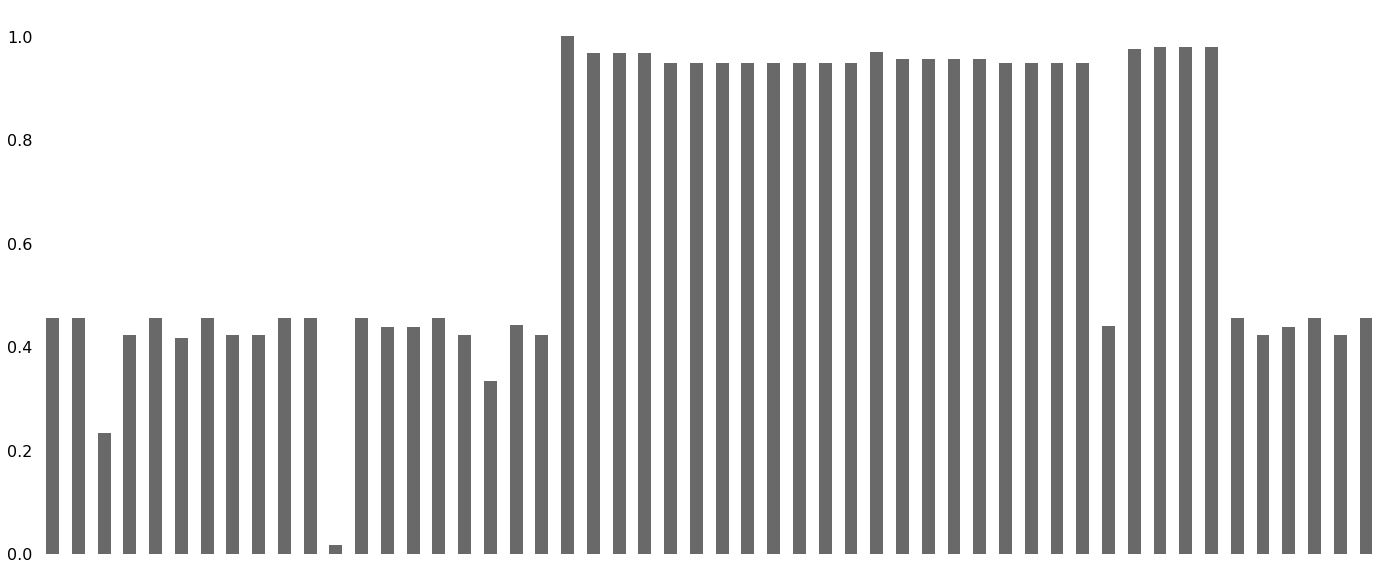

In [21]:
# Her Let's take a look at out dataset and visualize the missing values
overview(dhs_ml_final_df)
msn.bar(dhs_ml_final_df)

In [22]:
# Describe the df for later binning 
dhs_ml_final_df.describe()

,Gave.child.plain.water,Gave.child.juice,Gave.child.tea.or.coffee,Gave.child.tinned..powdered.or.fresh.milk,Gave.child.baby.formula,Gave.child.soup.clear.broth,Gave.child.other.liquid,Gave.child.bread..noodles..other.made.from.grains,Gave.child.potatoes..cassava..or.other.tubers,Gave.child.eggs,...,Population_2015,Travel_time_to_cities,Soil_suit_overall,Soil_suit_cereals,eggs,dairy,meat_fish,nuts_pulses,grains_tubers,animal_source_foods
count,15344.000000,15326.000000,7850.000000,14222.000000,15345.000000,14025.000000,15345.000000,14221.000000,14224.000000,15345.000000,...,1.478800e+04,32939.000000,32961.000000,32931.000000,15345.000000,14236.000000,14736.000000,15340.000000,14224.000000,15345.000000
mean,0.779874,0.148349,0.238590,0.175012,0.075012,0.180148,0.243802,0.539949,0.238009,0.179753,...,9.955789e+04,84.798110,3.688729,4.846408,0.179753,0.307593,0.214108,0.214947,0.771712,0.660764
std,0.187198,0.171165,0.311589,0.182251,0.124764,0.182340,0.207589,0.199368,0.183422,0.180282,...,3.444210e+05,182.562834,2.446650,1.706362,0.180282,0.292580,0.180763,0.196897,0.307004,0.427353
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.093558e-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.714286,0.000000,0.000000,0.039599,0.000000,0.050290,0.111111,0.436736,0.125000,0.055462,...,1.931279e+03,15.276630,1.522746,3.683363,0.055462,0.125000,0.080890,0.085714,0.607393,0.400754
50%,0.818182,0.108695,0.100000,0.137900,0.036634,0.141489,0.206667,0.534542,0.221830,0.142929,...,1.048634e+04,36.842740,4.077061,4.945596,0.142929,0.250000,0.201016,0.172891,0.752357,0.621857
75%,0.892309,0.200000,0.400000,0.238095,0.099777,0.250000,0.332966,0.646435,0.319817,0.246375,...,5.204177e+04,89.269055,5.743971,5.965635,0.246375,0.400000,0.305816,0.285714,0.916667,0.839160
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,8.896291e+06,4653.946000,8.809972,8.998034,1.000000,3.000000,2.000000,1.000000,2.000000,6.000000


In [23]:
def draw_heat_map(df):
    """This is a function that uses seaborn's heatmap function to show correlations between our predictors and the outcome variables. """
    df_mat = df.corr()
    df_fig = plt.figure(figsize = (15,15))
    sb.heatmap(df_mat, vmax = .9, square = True, annot=True)

In [24]:

def separate_training_testing(myData):
    """
    This function seperates the training sets and validation sets.
    """
    valueArray = myData.values
    X = valueArray[:, 0:myData.shape[1] - 1]
    Y = valueArray[:, myData.shape[1] - 1]
    test_size = 0.15
    seed = 7
    X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size=test_size, random_state=seed)
    return X_train, X_validate, Y_train, Y_validate


In [25]:
# Check if there is any low variance 
# Code from https://www.programcreek.com/python/example/93973/sklearn.feature_selection.VarianceThreshold
def feature_select(df):
    x_train, x_test, y_train, y_test = separate_training_testing(df)
    selector = VarianceThreshold()
    selector.fit(x_train, y_train)

    # Retain the feature names
    features = selector.get_support(indices = True)  # Returns array of indexes of nonremoved features
#     features = [column for column in df[features] if column != target]  # Gets feature names
    print(features)

### Machine Learning 

In [26]:
def string_to_int(df, col_name):
    """
    This is a helper function for converting the string labels to numerical
    """
    m = {}
    for i,e in enumerate(df[col_name].unique()):
        m.update({e: i})
    return m

In [27]:
def create_bins_width(df, col_name, bin_width):
    """
    This function cuts bins using equal width method
    """
    max = df[col_name].max()
    min = df[col_name].min()
    bins = np.arange(min, max, bin_width)
    print('This cuts the {} array into {} bins in equal width'.format(col_name,len(bins)))
    new_col_name = col_name + "_group"
    df[new_col_name] = np.digitize(df[col_name], bins)
    return df


def create_bins_depth(df, col_name, bin_num):
    """
    This function cuts bins using equal depth method
    """
    new_col_name = col_name + "_group"
    df[new_col_name],bins= pd.qcut(df[col_name],bin_num, retbins=True, labels=list(range(bin_num)))
    print('This cuts the {} array into {} result in {} bins in equal depth'.format(col_name,bins,bin_num))
    df[new_col_name] = df[new_col_name].astype(int)
    df = df.drop(col_name, axis=1)
    return df 

In [169]:
def clean_data(df):
    """
    This function cleans the dataset by 
    1) dropping the missing values
    2) binnning athe values. 
    """
    
    #   Making an assumption here that NA religion is no religion. 
    df["Primary_Religion"] = df["Primary_Religion"].fillna("No Religion")
    
    result_df = df.dropna()
    
    m = string_to_int(result_df, "Primary_Religion")
    result_df["Primary_Religion"] = result_df["Primary_Religion"].map(m)
    create_bins_width(result_df,"Travel_time_to_cities",10)
    create_bins_width(result_df,"Soil_suit_overall",2)
    create_bins_width(result_df,"Soil_suit_cereals",2)
    
    for c in dhs_predictor_consump_cols:
        result_df = create_bins_width(result_df,c,5)
    
    for p in dhs_predictor_production_cols:
        result_df = create_bins_width(result_df,p,500)
        
    create_bins_width(result_df,'ari_employment value (AVG 2011-2013)',5)
    create_bins_width(result_df,'Agricultural Emissions (CO2eq)',10000)
    create_bins_width(result_df,'Protected_Terrestrial',10)
    create_bins_width(result_df,'Forest_change',1)
    create_bins_width(result_df,'Redlist',0.15)
    create_bins_width(result_df,'Freshwater',2)
    
    
    result_df["agri_gdp_percentage(AVG from 2011 to 2013)"].astype(float,inplace = True)
    result_df["AVG GDP 2011-2013 Constant 2010"].astype(float,inplace = True)
    
#     create_bins_width(result_df,"PerCapita_GDP_2015",1000)
    create_bins_width(result_df,"Population_2015",5000)
    
    create_bins_width(result_df,"agri_gdp_percentage(AVG from 2011 to 2013)",5)
    create_bins_width(result_df,"AVG GDP 2011-2013 Constant 2010",1000000)
    
    return result_df

In [170]:
def clean_outcome(df,col):
    """
    This function cleans our outcome variables.abs 
    It converts continous value into categorical value by cutting them into different bins.
    All the bins same size. 
    """
    df.dropna(inplace = True)
    if col == "eggs" or col == "nuts_pulses":
        result_df = create_bins_width(df,col,0.25)
    else:
        result_df = create_bins_width(df,col,0.5)
    
    result_df = result_df[[col+'_group',"Cell_Order"]]
    return result_df
    

In [172]:
# Gather the desired cols that we will be using. 
desired_cols = dhs_predictor_socio_cols + \
                      dhs_predictor_consump_cols + \
                      dhs_predictor_production_cols +\
                    dhs_predictor_env_cols +\
                     dhs_predictor_other_cols 

# Instead of dropping na with the whole dataset which might cause loosing data entries, I am going to seperate the outcome variabels.
cleaned_dhs_df = clean_data(dhs_ml_final_df[desired_cols + ["Cell_Order"]])

This cuts the Travel_time_to_cities array into 322 bins in equal width
This cuts the Soil_suit_overall array into 5 bins in equal width
This cuts the Soil_suit_cereals array into 5 bins in equal width
This cuts the Cons_kg.yr Cereals - Excluding Beer array into 43 bins in equal width
This cuts the Cons_kg.yr Eggs array into 4 bins in equal width
This cuts the Cons_kg.yr Fish, Seafood array into 11 bins in equal width
This cuts the Cons_kg.yr Meat array into 19 bins in equal width
This cuts the Cons_kg.yr Milk - Excluding Butter array into 67 bins in equal width
This cuts the Cons_kg.yr Nuts_and_Seeds array into 7 bins in equal width
This cuts the Cons_kg.yr Pulses array into 8 bins in equal width
This cuts the Cons_kg.yr Starchy Roots array into 81 bins in equal width
This cuts the Fish, Seafood array into 114 bins in equal width
This cuts the Bovine_Sheep_Pigmeat_Poultry array into 162 bins in equal width
This cuts the Milk_Egg array into 272 bins in equal width
This cuts the Cereals 

In [161]:
desired_group_cols = [i+"_group" for i in desired_cols]
desired_group_cols.append("Cell_Order")
desired_group_cols.remove('Primary_Religion_group')
desired_group_cols.append('Primary_Religion')
cleaned_dhs_grouped_df = cleaned_dhs_df[desired_group_cols] 

In [162]:
cleaned_egg_df = clean_outcome(dhs_ml_final_df[["eggs","Cell_Order"]],"eggs")
cleaned_ml_egg_df = cleaned_egg_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_egg_df = cleaned_ml_egg_df[desired_group_cols + ["eggs_group"]]
cleaned_ml_egg_df.drop(["Cell_Order"], axis=1,inplace = True)
cleaned_ml_egg_df.head()

This cuts the eggs array into 4 bins in equal width


,ari_employment value (AVG 2011-2013)_group,agri_gdp_percentage(AVG from 2011 to 2013)_group,AVG GDP 2011-2013 Constant 2010_group,Agricultural Emissions (CO2eq)_group,Protected_Terrestrial_group,Forest_change_group,Redlist_group,Freshwater_group,Population_2015_group,Travel_time_to_cities_group,Soil_suit_overall_group,Soil_suit_cereals_group,Primary_Religion,eggs_group
0,4,2,143040,3,1,6,2,5,1,9,5,5,0,2
1,6,2,6613,1,1,1,3,5,1,8,5,5,0,1
2,6,2,6613,1,1,1,3,5,1,10,5,5,0,1
3,6,2,6613,1,1,1,3,5,2,10,4,4,0,2
4,4,2,143040,3,1,6,2,5,4,6,5,5,0,1


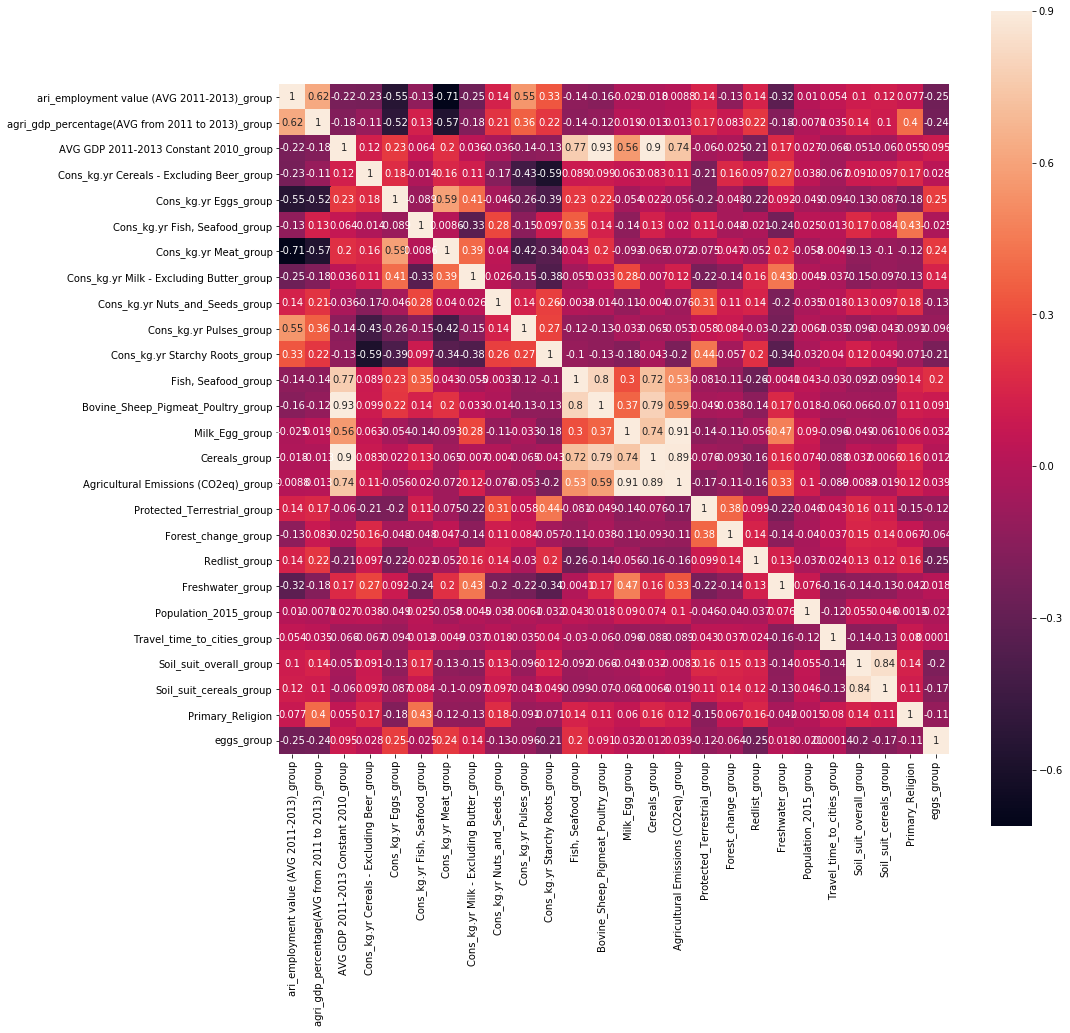

In [144]:
# Let's look at the heapmap of egg
draw_heat_map(cleaned_ml_egg_df)

In [145]:
overview(cleaned_ml_egg_df)

Datasets shape Rows:6060 Columns:26
----------Number of Missing Values in Each Column------------
ari_employment value (AVG 2011-2013)_group          0
agri_gdp_percentage(AVG from 2011 to 2013)_group    0
AVG GDP 2011-2013 Constant 2010_group               0
Cons_kg.yr Cereals - Excluding Beer_group           0
Cons_kg.yr Eggs_group                               0
Cons_kg.yr Fish, Seafood_group                      0
Cons_kg.yr Meat_group                               0
Cons_kg.yr Milk - Excluding Butter_group            0
Cons_kg.yr Nuts_and_Seeds_group                     0
Cons_kg.yr Pulses_group                             0
Cons_kg.yr Starchy Roots_group                      0
Fish, Seafood_group                                 0
Bovine_Sheep_Pigmeat_Poultry_group                  0
Milk_Egg_group                                      0
Cereals_group                                       0
Agricultural Emissions (CO2eq)_group                0
Protected_Terrestrial_group           

In [146]:
# I am also interested in precision and recall score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [147]:
def draw_roc_curve(name, model, X_validate, Y_validate):
    """
    This functions draws ROC graphs.
    """
    predicted_probas = model.predict_proba(X_validate)
    skplt.metrics.plot_roc(Y_validate, predicted_probas, title = "Roc Curve of {}".format(name))
    plt.show()
    # uncomment here to save the plots
    # plt.savefig(name)


def plot_confusion_matrix(Y_pred, Y_validate, name, out_come):
    """
    This function plots the confusion matrix.
    """

    skplt.metrics.plot_confusion_matrix(Y_validate, Y_pred,title = "Predicting {} Using {} Confusion Matrix".format(out_come, name))
    plt.show()
    
    # uncomment here to save the plots(Included in the write-up)
    # plt.savefig("cnf_matrix " + name)


def model_evaluate(X_train, X_validate, Y_train, Y_validate, num_folds, num_instances, seed, scoring, models, out_come, no_kfold):
    """
    This function handles evaluation of machine learning methods using cross validation 
    """
    results = []
    for name, model in models:

        # Get a prediction
        trained_model = model.fit(X_train, Y_train)
            
        Y_pred = trained_model.predict(X_validate)
        
        # Plot the condusion matrix and Roc curve
        plot_confusion_matrix(Y_pred, Y_validate, name, out_come)
#         draw_roc_curve(name, trained_model, X_validate, Y_validate)
        print("Predicting {} Using {} Accuracy: {} Precision:{} Recall:{}".format(out_come,name
                                                                                  ,accuracy_score(Y_validate,Y_pred)
                                                                                  ,precision_score(Y_validate,Y_pred,average='macro')
                                                                                  ,recall_score(Y_validate,Y_pred,average='macro')))
        # Evalutate out models 
        # TODO 
        if no_kfold == False:
            kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=False)
            cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
            results.append(cv_results)
            msg = "Predicting {} Using {} model's accuracy is {}, with a standard deviation of {}".format(out_come, name, cv_results.mean(), cv_results.std())
            print(msg)
        elif no_kfold:
            print(model.best_params_)
                
def perform_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    models = [('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()),
                    ('RFC', RandomForestClassifier()), ('NB', GaussianNB())
#                     ,('SVM', svm.SVC(gamma=0.001, decision_function_shape='ovo', probability=True))
             ]
    
#     models = [('RFC', RandomForestClassifier())]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', models, out_come,False)

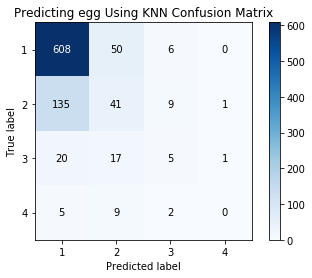

Predicting egg Using KNN Accuracy: 0.7194719471947195 Precision:0.3423416860916861 Recall:0.31309295697418327
Predicting egg Using KNN model's accuracy is 0.711905622036577, with a standard deviation of 0.01672552848022237


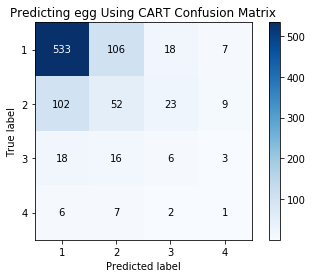

Predicting egg Using CART Accuracy: 0.6512651265126512 Precision:0.3171357528079852 Recall:0.3210789048918856
Predicting egg Using CART model's accuracy is 0.645895988560247, with a standard deviation of 0.01652698516083473


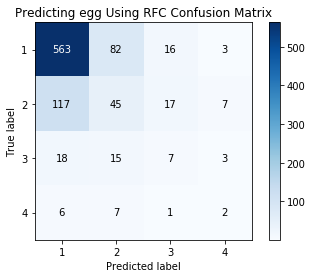

Predicting egg Using RFC Accuracy: 0.6787678767876788 Precision:0.35144859314002685 Recall:0.34440443695261164
Predicting egg Using RFC model's accuracy is 0.6833672010235569, with a standard deviation of 0.015990909676690923


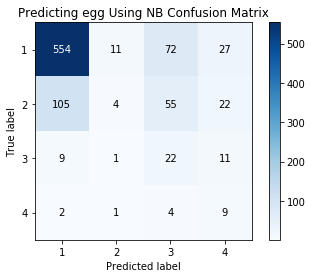

Predicting egg Using NB Accuracy: 0.647964796479648 Precision:0.334096355392687 Recall:0.4824926581796052
Predicting egg Using NB model's accuracy is 0.6136787837736133, with a standard deviation of 0.038953910782113875


In [148]:
perform_ml(cleaned_ml_egg_df,"egg")

### Result

It seems like the algorithm is able to predict the lower level class better. It completely fails in predicting the highist level class in all algorithms.


This could be that there is not enough data in the higher class for the algorithm to learn. From the heap map we drew, we can also see that none of the features has a strong correlation with our outcome variable. To improve this we'll first try to look at the number of entries in each class for our outcome variable, and adjust the bins accordingly. Then we will try a few performance improving method such as boosting and bagging. Lastly we will explore other available datasets to serve as features. 

#####  Count Number of Entries in Each Class

In [43]:
for i in range(1,cleaned_ml_egg_df["eggs_group"].max()+1):
    print("Class {} has {} entries".format(i,cleaned_ml_egg_df[cleaned_ml_egg_df["eggs_group"] == i].shape[0]))

Class 1 has 4382 entries
Class 2 has 1193 entries
Class 3 has 369 entries
Class 4 has 116 entries


We can see that the lower two classes have very little numbers of entries.Our bins are not very evenly distributed. Let's try tweakin the bin size. 

#####  More with other outcome variables.
Before we try to improve the performance, let's finish performing machine learning on all other variables. 

This cuts the dairy array into 6 bins in equal width


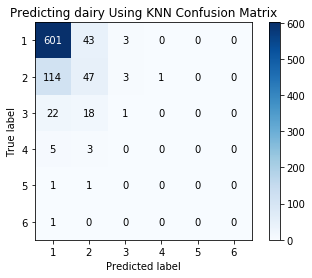

Predicting dairy Using KNN Accuracy: 0.7511574074074074 Precision:0.22838261648745517 Recall:0.20635689271041932
Predicting dairy Using KNN model's accuracy is 0.7666015608697465, with a standard deviation of 0.015376155702678416


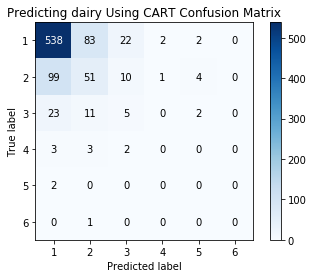

Predicting dairy Using CART Accuracy: 0.6875 Precision:0.21325159396512275 Recall:0.21042871128444318
Predicting dairy Using CART model's accuracy is 0.7240908142398064, with a standard deviation of 0.017194065773105997


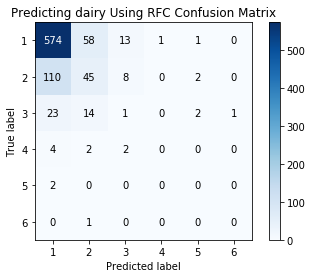

Predicting dairy Using RFC Accuracy: 0.7175925925925926 Precision:0.20361929250428548 Recall:0.19738151294678605
Predicting dairy Using RFC model's accuracy is 0.7447360293810775, with a standard deviation of 0.018067602870854703


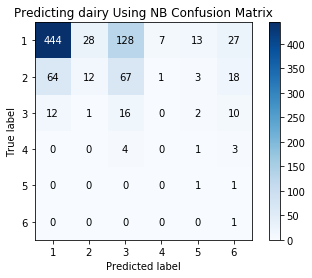

Predicting dairy Using NB Accuracy: 0.5486111111111112 Precision:0.21460239199887524 Recall:0.4415358965308074
Predicting dairy Using NB model's accuracy is 0.561227828554735, with a standard deviation of 0.04399512826348248
This cuts the meat_fish array into 4 bins in equal width


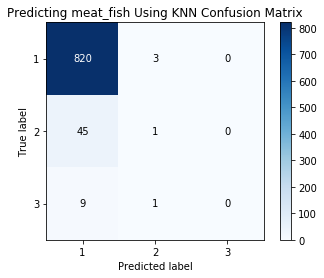

Predicting meat_fish Using KNN Accuracy: 0.9340159271899886 Precision:0.3794050343249428 Recall:0.339364643316252
Predicting meat_fish Using KNN model's accuracy is 0.9341365461847388, with a standard deviation of 0.008462372492251204


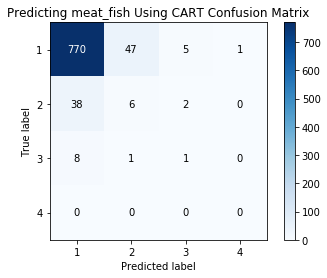

Predicting meat_fish Using CART Accuracy: 0.8839590443686007 Precision:0.2949346405228758 Recall:0.29150906017222256
Predicting meat_fish Using CART model's accuracy is 0.8929718875502008, with a standard deviation of 0.010551248719212557


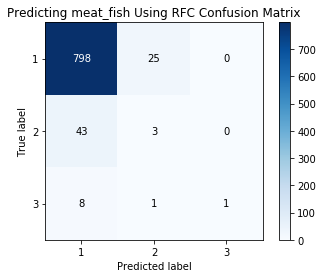

Predicting meat_fish Using RFC Accuracy: 0.9124004550625711 Precision:0.6811258681613257 Recall:0.37828024019581946
Predicting meat_fish Using RFC model's accuracy is 0.914859437751004, with a standard deviation of 0.008853577383553668


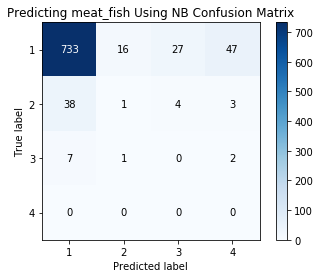

Predicting meat_fish Using NB Accuracy: 0.8350398179749715 Precision:0.24942873464724366 Recall:0.22809577896349517
Predicting meat_fish Using NB model's accuracy is 0.8329317269076306, with a standard deviation of 0.021037431090295267
This cuts the nuts_pulses array into 4 bins in equal width


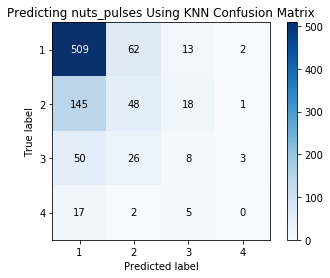

Predicting nuts_pulses Using KNN Accuracy: 0.6215621562156216 Precision:0.3089020519370878 Recall:0.29674244998049626
Predicting nuts_pulses Using KNN model's accuracy is 0.6370873786407767, with a standard deviation of 0.01166503945310727


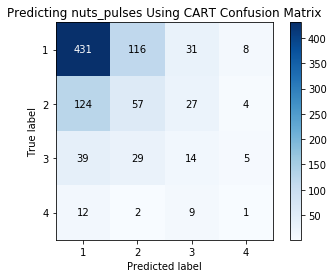

Predicting nuts_pulses Using CART Accuracy: 0.5533553355335533 Precision:0.3047569871366222 Recall:0.3017372529927322
Predicting nuts_pulses Using CART model's accuracy is 0.5914563106796116, with a standard deviation of 0.012317476914294157


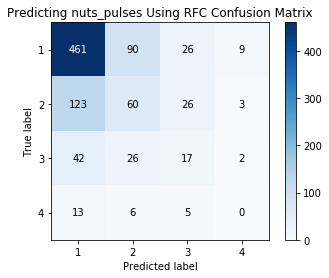

Predicting nuts_pulses Using RFC Accuracy: 0.5918591859185919 Precision:0.3202099522522058 Recall:0.31627764664258123
Predicting nuts_pulses Using RFC model's accuracy is 0.6242718446601943, with a standard deviation of 0.010356998332500651


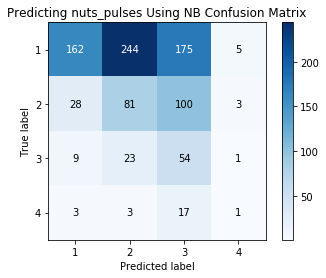

Predicting nuts_pulses Using NB Accuracy: 0.3278327832783278 Precision:0.3222046982377207 Recall:0.33022057637064656
Predicting nuts_pulses Using NB model's accuracy is 0.30271844660194175, with a standard deviation of 0.032228915402616826
This cuts the grains_tubers array into 4 bins in equal width


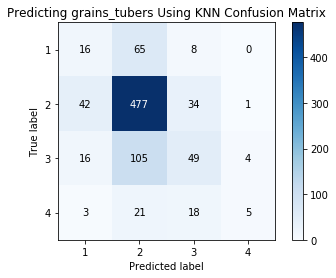

Predicting grains_tubers Using KNN Accuracy: 0.6331018518518519 Precision:0.46785133712082566 Recall:0.3571945713373723
Predicting grains_tubers Using KNN model's accuracy is 0.6262539126079879, with a standard deviation of 0.01399773265649633


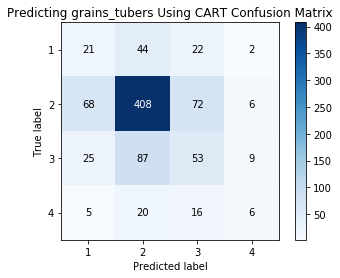

Predicting grains_tubers Using CART Accuracy: 0.5648148148148148 Precision:0.37309207601805466 Recall:0.3511686064150254
Predicting grains_tubers Using CART model's accuracy is 0.5687980468260924, with a standard deviation of 0.018340670890374697


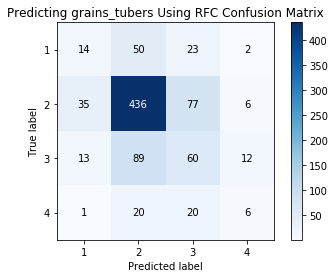

Predicting grains_tubers Using RFC Accuracy: 0.5972222222222222 Precision:0.37977447389212093 Recall:0.35419853539245044
Predicting grains_tubers Using RFC model's accuracy is 0.6088731688994616, with a standard deviation of 0.023729554364482756


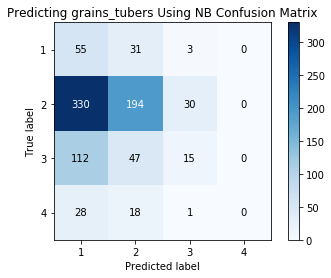

Predicting grains_tubers Using NB Accuracy: 0.3055555555555556 Precision:0.26996246774571897 Recall:0.26359123251419353
Predicting grains_tubers Using NB model's accuracy is 0.3259104377947498, with a standard deviation of 0.04919237763228045
This cuts the animal_source_foods array into 12 bins in equal width


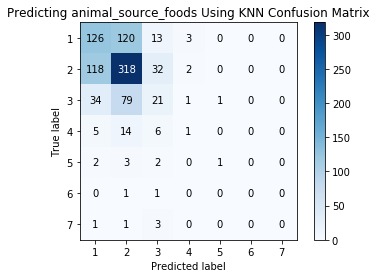

Predicting animal_source_foods Using KNN Accuracy: 0.5137513751375138 Precision:0.27799013353384355 Recall:0.2107692969118033
Predicting animal_source_foods Using KNN model's accuracy is 0.5325144878452622, with a standard deviation of 0.02448215768003524


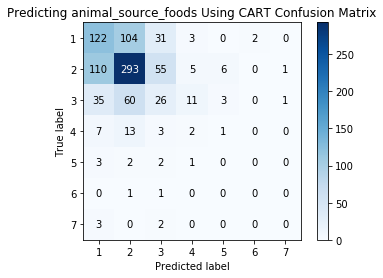

Predicting animal_source_foods Using CART Accuracy: 0.48734873487348734 Precision:0.1946771943449684 Recall:0.19387895111318473
Predicting animal_source_foods Using CART model's accuracy is 0.471559795288628, with a standard deviation of 0.012294055295725156


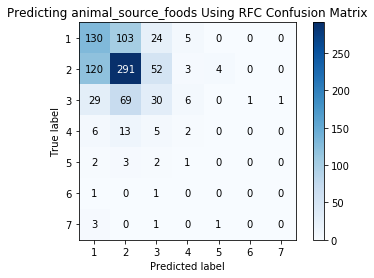

Predicting animal_source_foods Using RFC Accuracy: 0.49834983498349833 Precision:0.20468109669285228 Recall:0.20183477921346824
Predicting animal_source_foods Using RFC model's accuracy is 0.49679686912019266, with a standard deviation of 0.014647294528461485


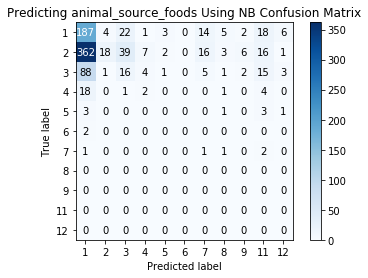

Predicting animal_source_foods Using NB Accuracy: 0.24642464246424642 Precision:0.13102513738901295 Recall:0.10423713328202719
Predicting animal_source_foods Using NB model's accuracy is 0.233550462858433, with a standard deviation of 0.015216944510845654


In [44]:
# Try it with all others! 
for out_come in dhs_outcome_cols:
    if out_come != "eggs":
        cleaned_outcome_df = clean_outcome(dhs_ml_final_df[[out_come,"Cell_Order"]],out_come)
        cleaned_ml_outcome_df = cleaned_outcome_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
        cleaned_ml_outcome_df = cleaned_ml_outcome_df[desired_group_cols + ["{}_{}".format(out_come,"group")]]
        cleaned_ml_outcome_df.drop(["Cell_Order"], axis=1,inplace = True)
        perform_ml(cleaned_ml_outcome_df,out_come)


##### Try a few Machine Learning Improving Methods 
1) Boosting https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5
    - In this section we will try: Adaboost XGBoost and GradientBoost
    - Decrease Bias 
2) Bagging https://stats.stackexchange.com/questions/18891/bagging-boosting-and-stacking-in-machine-learning
    - Decrease Variance 
    - In this section, we will try using bagging with our existing models used above. 
    - *Random tree is a bagged algorithm of decision treee

In [51]:
# Boosting 
# Adaboost https://www.datacamp.com/community/tutorials/adaboost-classifier-python
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

In [52]:

def perform_boosting_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction.
    Here we are using the default base estimator which is decision tree.
    """
    boosted_models = [('Ada', AdaBoostClassifier(n_estimators=50,learning_rate=1))
                      ,('GB', GradientBoostingClassifier(n_estimators=50,learning_rate=1))
                     ,('XGB', XGBClassifier(n_estimators=50,learning_rate=1))]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', boosted_models, out_come,False)


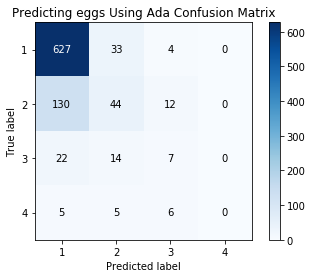

Predicting eggs Using Ada Accuracy: 0.7458745874587459 Precision:0.37486438540933614 Recall:0.33590673647327496
Predicting eggs Using Ada model's accuracy is 0.7350071498457139, with a standard deviation of 0.0169497673821032


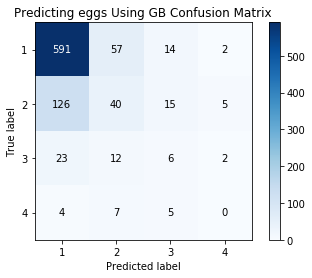

Predicting eggs Using GB Accuracy: 0.7007700770077008 Precision:0.32229560622914344 Recall:0.3111622220314115
Predicting eggs Using GB model's accuracy is 0.7018089109656054, with a standard deviation of 0.023801667773860093


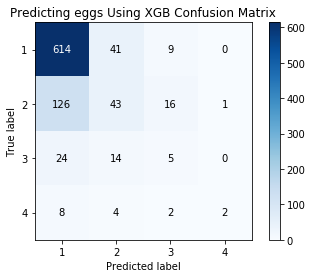

Predicting eggs Using XGB Accuracy: 0.7304730473047305 Precision:0.5099555204206034 Recall:0.34929016516177236
Predicting eggs Using XGB model's accuracy is 0.7274339580040642, with a standard deviation of 0.01752649129634333


In [53]:
perform_boosting_ml(cleaned_ml_egg_df,"eggs")

In [54]:

from sklearn.model_selection import GridSearchCV

In [57]:
#Bagging 
from sklearn.ensemble import BaggingClassifier

In [58]:
def perform_bagging_ml(df,out_come):
    """
    This function is the driver code for this machine learning prediction
    Args:
        bin_class: A boolean variable decides if we bin our label(MMD) or not. 
    """
    bagged_models = [('KNN', BaggingClassifier(base_estimator= KNeighborsClassifier(), n_estimators=10, max_samples=10, max_features=1.0))
                       , ('CART', BaggingClassifier(base_estimator= DecisionTreeClassifier(), n_estimators=10, max_samples=10, max_features=1.0))
                    ,('NB', BaggingClassifier(base_estimator= GaussianNB(), n_estimators=10, max_samples=10, max_features=1.0))]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', bagged_models, out_come, False)

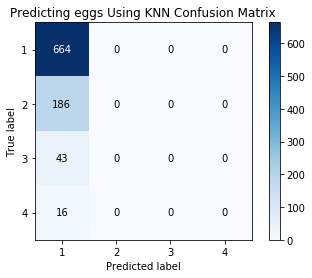

Predicting eggs Using KNN Accuracy: 0.7304730473047305 Precision:0.18261826182618263 Recall:0.25
Predicting eggs Using KNN model's accuracy is 0.7218085346579363, with a standard deviation of 0.021185941853217684


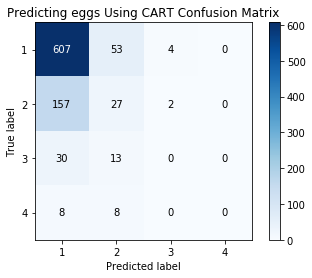

Predicting eggs Using CART Accuracy: 0.6974697469746974 Precision:0.25604614700871586 Recall:0.2648294792071512
Predicting eggs Using CART model's accuracy is 0.7097753443215173, with a standard deviation of 0.026833656126190424


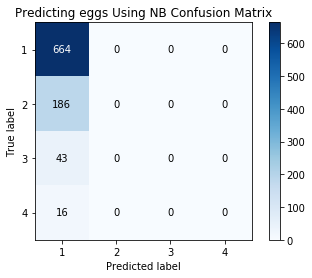

Predicting eggs Using NB Accuracy: 0.7304730473047305 Precision:0.18261826182618263 Recall:0.25
Predicting eggs Using NB model's accuracy is 0.7218085346579363, with a standard deviation of 0.021185941853217684


In [59]:
perform_bagging_ml(cleaned_ml_egg_df,"eggs")

The accuracy is about the same.  I don't think I'll go further into this. 

### New Binning Strategies 

Since our egg class is not very evenly distributed, we are going to divide it more evenly and see if it improves our model performance.
We will first try to bin them so that each class will have equal number of entries. 
If the bin edges are not good enough, we will first build a histogram, and then bin them accordingly.

In [60]:
egg_df = dhs_ml_final_df[["eggs","Cell_Order"]].dropna()

In [61]:


equal_depth_egg_df = create_bins_depth(egg_df,"eggs",4)

cleaned_ml_equal_depth_egg_df = equal_depth_egg_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_equal_depth_egg_df = cleaned_ml_equal_depth_egg_df[desired_group_cols + ["eggs_group"]]
cleaned_ml_equal_depth_egg_df.drop(["Cell_Order"], axis=1,inplace = True)


This cuts the eggs array into [0.         0.05546218 0.14292923 0.2463752  1.        ] result in 4 bins in equal depth


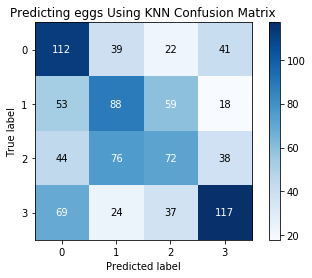

Predicting eggs Using KNN Accuracy: 0.42794279427942794 Precision:0.4290548091158204 Recall:0.428440474884784
Predicting eggs Using KNN model's accuracy is 0.434479190185896, with a standard deviation of 0.02162639233346289


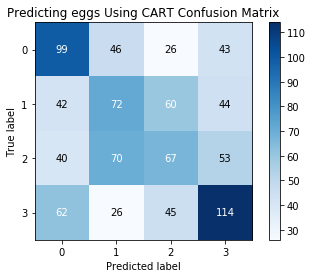

Predicting eggs Using CART Accuracy: 0.3872387238723872 Precision:0.38276468538997055 Recall:0.38643371528806336
Predicting eggs Using CART model's accuracy is 0.39059908180928726, with a standard deviation of 0.021597416309032537


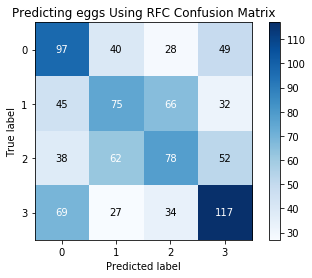

Predicting eggs Using RFC Accuracy: 0.40374037403740376 Precision:0.40096151711357136 Recall:0.4025305926485035
Predicting eggs Using RFC model's accuracy is 0.41583540302551364, with a standard deviation of 0.022077409555905748


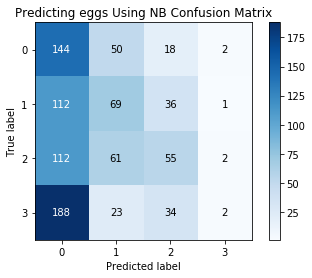

Predicting eggs Using NB Accuracy: 0.297029702970297 Precision:0.3173059884793946 Recall:0.30915963962602094
Predicting eggs Using NB model's accuracy is 0.2980036878151577, with a standard deviation of 0.016718753316356267


In [62]:
perform_ml(cleaned_ml_equal_depth_egg_df,"eggs")

As we can see, the bin edges are very small, and barely useful. 

In [163]:
# This new binning method is not so great. 
# Gonna try differnt method

bins = [0,0.1,0.2,0.5]
egg_df["eggs_group"] = np.digitize(egg_df["eggs"], bins)
cleaned_ml_our_bin_egg_df = egg_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_our_bin_egg_df = cleaned_ml_our_bin_egg_df[desired_group_cols + ["eggs_group"]]
cleaned_ml_our_bin_egg_df.drop(["Cell_Order"], axis=1,inplace = True)

In [164]:
cleaned_ml_our_bin_egg_df.head()

,ari_employment value (AVG 2011-2013)_group,agri_gdp_percentage(AVG from 2011 to 2013)_group,AVG GDP 2011-2013 Constant 2010_group,Agricultural Emissions (CO2eq)_group,Protected_Terrestrial_group,Forest_change_group,Redlist_group,Freshwater_group,Population_2015_group,Travel_time_to_cities_group,Soil_suit_overall_group,Soil_suit_cereals_group,Primary_Religion,eggs_group
0,4,2,143040,3,1,6,2,5,1,9,5,5,0,3
1,6,2,6613,1,1,1,3,5,1,8,5,5,0,1
2,6,2,6613,1,1,1,3,5,1,10,5,5,0,2
3,6,2,6613,1,1,1,3,5,2,10,4,4,0,3
4,4,2,143040,3,1,6,2,5,4,6,5,5,0,1


In [165]:
def check_num_in_class(df,col_name):
    for i in range(1,df[col_name].max()+1):
        print("Class {} has {} entries".format(i,df[df[col_name] == i].shape[0]))

In [166]:
check_num_in_class(cleaned_ml_our_bin_egg_df,"eggs_group")

Class 1 has 2067 entries
Class 2 has 1950 entries
Class 3 has 1842 entries
Class 4 has 485 entries


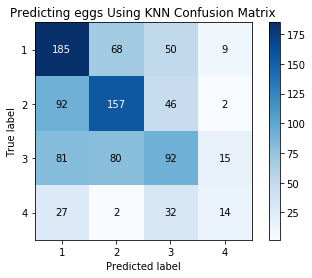

Predicting eggs Using KNN Accuracy: 0.47058823529411764 Precision:0.4400254875417742 Recall:0.41287962383111637
Predicting eggs Using KNN model's accuracy is 0.45808596165739024, with a standard deviation of 0.01826683761942536


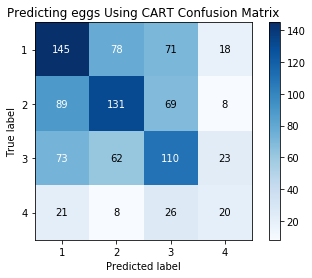

Predicting eggs Using CART Accuracy: 0.4264705882352941 Precision:0.400003254503092 Recall:0.3957338646704318
Predicting eggs Using CART model's accuracy is 0.4044884216312788, with a standard deviation of 0.017769376822836438


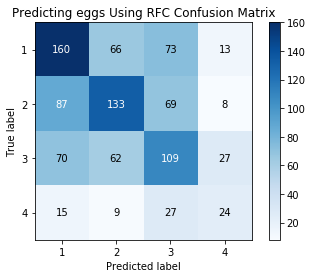

Predicting eggs Using RFC Accuracy: 0.4474789915966387 Precision:0.42498499192613776 Recall:0.4218370946356021
Predicting eggs Using RFC model's accuracy is 0.43434377791520645, with a standard deviation of 0.024878842300437853


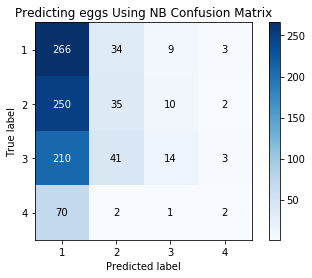

Predicting eggs Using NB Accuracy: 0.3329831932773109 Precision:0.31460889003842746 Recall:0.26232867326150905
Predicting eggs Using NB model's accuracy is 0.3358726723012437, with a standard deviation of 0.02270118460149326


In [167]:
perform_ml(cleaned_ml_our_bin_egg_df,"eggs")

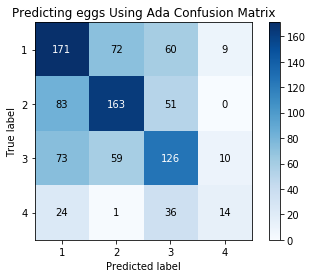

Predicting eggs Using Ada Accuracy: 0.49789915966386555 Precision:0.4813756864604323 Recall:0.43842859807412055
Predicting eggs Using Ada model's accuracy is 0.482379921665636, with a standard deviation of 0.021290048842143056


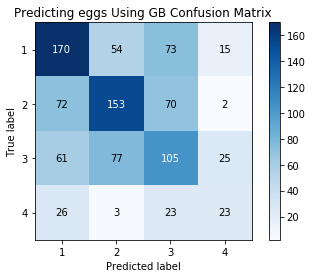

Predicting eggs Using GB Accuracy: 0.4737394957983193 Precision:0.4477795997272575 Recall:0.439620255366524
Predicting eggs Using GB model's accuracy is 0.47959939531368095, with a standard deviation of 0.024931792466191698


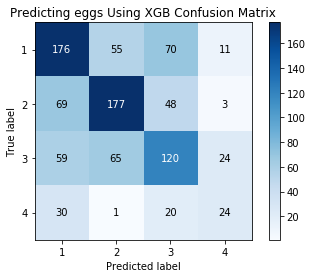

Predicting eggs Using XGB Accuracy: 0.5220588235294118 Precision:0.49327972314784274 Recall:0.48195583852300267
Predicting eggs Using XGB model's accuracy is 0.4957352435923864, with a standard deviation of 0.027588662013442882


In [168]:
perform_boosting_ml(cleaned_ml_our_bin_egg_df,"eggs")

### Run Best Models on Other Variables 

In [69]:
# Milk df 
# Since the dairy column is combined food group. might be better to use the single one. 

milk_bins = [0,0.1,0.2,0.5]

milk_df = dhs_ml_final_df[["Gave.child.tinned..powdered.or.fresh.milk","Cell_Order"]].dropna()
milk_df["milk_group"] = np.digitize(milk_df["Gave.child.tinned..powdered.or.fresh.milk"], milk_bins)
cleaned_ml_our_bin_milk_df = milk_df.merge(cleaned_dhs_grouped_df, how = "inner", on = "Cell_Order")
cleaned_ml_our_bin_milk_df = cleaned_ml_our_bin_milk_df[desired_group_cols + ["milk_group"]]
cleaned_ml_our_bin_milk_df.columns

Index(['ari_employment value (AVG 2011-2013)_group',
       'agri_gdp_percentage(AVG from 2011 to 2013)_group',
       'AVG GDP 2011-2013 Constant 2010_group',
       'Cons_kg.yr Cereals - Excluding Beer_group', 'Cons_kg.yr Eggs_group',
       'Cons_kg.yr Fish, Seafood_group', 'Cons_kg.yr Meat_group',
       'Cons_kg.yr Milk - Excluding Butter_group',
       'Cons_kg.yr Nuts_and_Seeds_group', 'Cons_kg.yr Pulses_group',
       'Cons_kg.yr Starchy Roots_group', 'Fish, Seafood_group',
       'Bovine_Sheep_Pigmeat_Poultry_group', 'Milk_Egg_group', 'Cereals_group',
       'Agricultural Emissions (CO2eq)_group', 'Protected_Terrestrial_group',
       'Forest_change_group', 'Redlist_group', 'Freshwater_group',
       'Population_2015_group', 'Travel_time_to_cities_group',
       'Soil_suit_overall_group', 'Soil_suit_cereals_group', 'Cell_Order',
       'Primary_Religion', 'milk_group'],
      dtype='object')

In [70]:
check_num_in_class(cleaned_ml_our_bin_milk_df,"milk_group")

Class 1 has 1910 entries
Class 2 has 1696 entries
Class 3 has 1600 entries
Class 4 has 549 entries


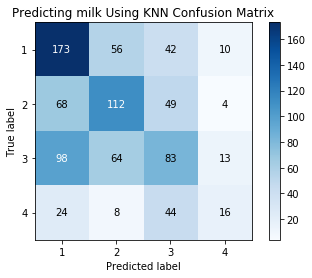

Predicting milk Using KNN Accuracy: 0.4444444444444444 Precision:0.42401941422879413 Recall:0.3979908820257859
Predicting milk Using KNN model's accuracy is 0.45144693460206164, with a standard deviation of 0.015901411173951076


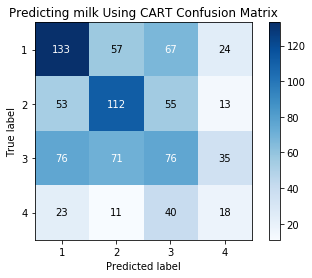

Predicting milk Using CART Accuracy: 0.3923611111111111 Precision:0.35805238430033365 Recall:0.36105553028594783
Predicting milk Using CART model's accuracy is 0.41177621969033007, with a standard deviation of 0.018532039393497273


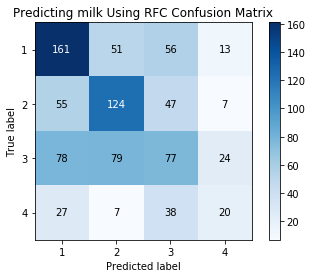

Predicting milk Using RFC Accuracy: 0.44212962962962965 Precision:0.4105911067534197 Recall:0.40524587365186204
Predicting milk Using RFC model's accuracy is 0.45532657234673, with a standard deviation of 0.01923724635440186


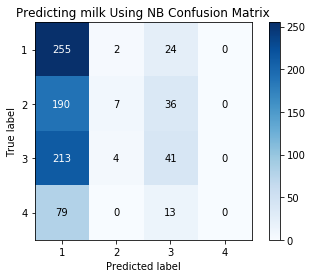

Predicting milk Using NB Accuracy: 0.3506944444444444 Precision:0.31102698689108743 Recall:0.2741077391864118
Predicting milk Using NB model's accuracy is 0.3610684028212512, with a standard deviation of 0.02013011065348151


In [71]:
perform_ml(cleaned_ml_our_bin_milk_df,"milk")

The bese model here is KNN

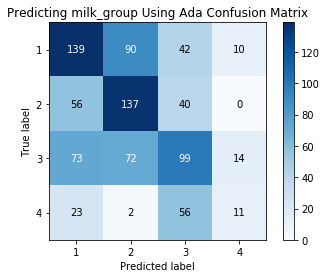

Predicting milk_group Using Ada Accuracy: 0.44675925925925924 Precision:0.4162049912936839 Recall:0.39648272548751834
Predicting milk_group Using Ada model's accuracy is 0.4845736822336296, with a standard deviation of 0.030476765831594508


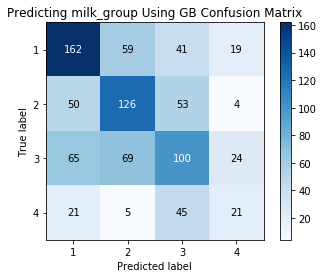

Predicting milk_group Using GB Accuracy: 0.47337962962962965 Precision:0.43933605470327025 Recall:0.43328568912371973
Predicting milk_group Using GB model's accuracy is 0.4845720128542215, with a standard deviation of 0.018629517840835965


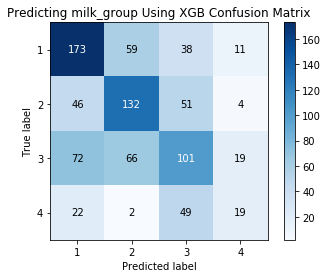

Predicting milk_group Using XGB Accuracy: 0.49189814814814814 Precision:0.460863218225434 Recall:0.4450441438717569
Predicting milk_group Using XGB model's accuracy is 0.5013380075956764, with a standard deviation of 0.023291086380043673


In [72]:
perform_boosting_ml(cleaned_ml_our_bin_milk_df,"milk_group")

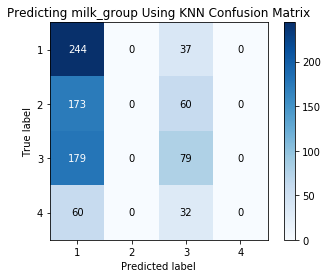

Predicting milk_group Using KNN Accuracy: 0.3738425925925926 Precision:0.18793972795497185 Recall:0.29363223813070705
Predicting milk_group Using KNN model's accuracy is 0.36106840282125124, with a standard deviation of 0.02143798349337543


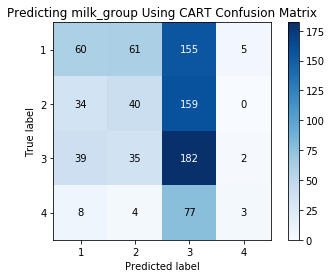

Predicting milk_group Using CART Accuracy: 0.3298611111111111 Precision:0.33221818191462843 Recall:0.2808080009141021
Predicting milk_group Using CART model's accuracy is 0.36475355786486374, with a standard deviation of 0.029787003949810657


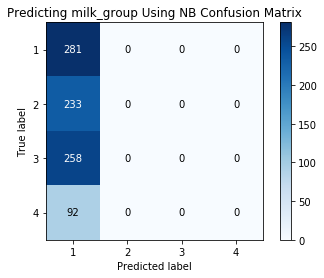

Predicting milk_group Using NB Accuracy: 0.32523148148148145 Precision:0.08130787037037036 Recall:0.25
Predicting milk_group Using NB model's accuracy is 0.3330612244897959, with a standard deviation of 0.02161887397390726


In [73]:
perform_bagging_ml(cleaned_ml_our_bin_milk_df,"milk_group")

### Fine Tune Hyperparameters on Milk
 
All the boosting models performed fairly better, and the best is XGBoost model for both egg and milk.
Bagging models are not so well. We will not consider these. 
Based on both egg and milk, we can see that boosted models perform better than regular ones in general. 


How Gradient Boosting Works
https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
Gradient boosting involves three elements:
- A loss function to be optimized.
- A weak learner to make predictions.
- An additive model to add weak learners to minimize the loss function.



Article on XGBoost 
https://towardsdatascience.com/xgboost-is-not-black-magic-56ca013144b4
Params Tuning reference 1: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/ 
Params Tuning reference 2:
This Param testing(All below code)completely follows reference 1 for our XGBoost model hyper-parameters tuning

Start with depth and child wieght. 

In [74]:
 from sklearn.preprocessing import label_binarize
X_train, X_validate, Y_train, Y_validate = separate_training_testing(cleaned_ml_our_bin_milk_df)
# Y_coded = label_binarize(Y, classes=[0, 1, 2, 3])

In [77]:
# Initializing our starting param dict
grid_search_dict = {"learning_rate":0.1, "n_estimators":140, "max_depth":5,
                                                      "min_child_weight":1, "gamma":0, "subsample":0.8, 
                                                     "colsample_bytree":0.8, "nthread":4, "scale_pos_weight":1, "seed":27}

def grid_search(param_dict,test_params):
    gsearch = GridSearchCV(estimator = XGBClassifier(**param_dict), 
    param_grid = test_params, scoring='accuracy',n_jobs=4,iid=False, cv=5)
    gsearch.fit(X_train,Y_train)
    print(gsearch.best_params_, gsearch.best_score_)

In [76]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
grid_search(grid_search_dict,param_test1)

KeyboardInterrupt: 

In [ ]:
test_1(param_test1)

Based on the previous search max 3 and min 5 is good. Here we check one up and one down since previous one is range 2. 

In [112]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[4,5,6]
}
grid_search(grid_search_dict,param_test2)

{'max_depth': 3, 'min_child_weight': 5} 0.5354763637355434


This remains unchanged. Move onto the next set of parameters. Gamma

In [78]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

# change max and min to our previous values. 
grid_search_dict['max_depth'] = 3
grid_search_dict['min_child_weight'] = 5
grid_search(grid_search_dict,param_test3)

In [114]:
param_test4 = {
 'subsample':[i/10.0 for i in range(3,10)],
 'colsample_bytree':[i/10.0 for i in range(3,10)]
}
grid_search(grid_search_dict,param_test4)

{'colsample_bytree': 0.6, 'subsample': 0.3} 0.5379309811103243


In [96]:
param_test5 = {
'colsample_bytree': [0.55,0.6,0.65],
 'subsample':[0.1,0.15,0.2,0.25,0.3]
}
grid_search(grid_search_dict,param_test5)

({'colsample_bytree': 0.6, 'subsample': 0.3}, 0.5379309811103243)

In [79]:
param_test6 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
# change max and min to our previous values. 
grid_search_dict['colsample_bytree'] = 0.6
grid_search_dict['subsample'] = 0.3

grid_search(grid_search_dict,param_test6)

In [116]:
param_test6 = {
 'n_estimators':[10*i for i in range(5,20)]
}
grid_search(grid_search_dict,param_test6)

{'n_estimators': 120} 0.538750024444089


In [80]:
grid_search_dict['n_estimators'] = 120

So our fine tuned hyper-params are:

max_depth: 3
min_child_weight: 5
gamma: 0.0
colsample_bytree: 0.6
subsample:0.3
reg_alpha: 0
n_estimators:120

acheived an accuracy of 0.538750024444089


In [81]:
grid_search_dict

{'learning_rate': 0.1,
 'n_estimators': 120,
 'max_depth': 3,
 'min_child_weight': 5,
 'gamma': 0,
 'subsample': 0.3,
 'colsample_bytree': 0.6,
 'nthread': 4,
 'scale_pos_weight': 1,
 'seed': 27}

In [86]:
def run_tuned_xgboost(df,out_come):
    """
    This function uses xgboost as the ensemble method to 
    predict the categories for our consumption data. 
    It also uses the hyperparameters we found proved having the best accuracy using the gridsearch function from sklearn
    """

    boosted_models = [('XGB', XGBClassifier(**grid_search_dict))]

    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
    model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', boosted_models, out_come,False)

    

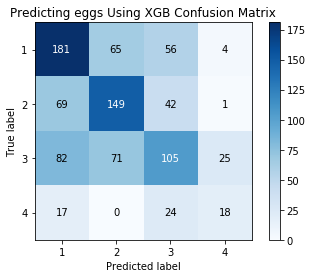

Predicting eggs Using XGB Accuracy: 0.49834983498349833 Precision:0.4697466813642414 Recall:0.45962349369313504
Predicting eggs Using XGB model's accuracy is 0.5103894784375707, with a standard deviation of 0.020576367804293547


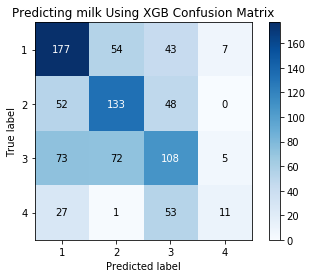

Predicting milk Using XGB Accuracy: 0.4965277777777778 Precision:0.48909117016193804 Recall:0.43471963940800895
Predicting milk Using XGB model's accuracy is 0.5344601644338717, with a standard deviation of 0.020219346350630264


In [85]:
run_tuned_xgboost(cleaned_ml_our_bin_egg_df,"eggs")
run_tuned_xgboost(cleaned_ml_our_bin_milk_df,"milk")

This improved a bit, which means if want it to increase for all outcomes, we need to probably tune it respectively. 

### Other Variables

In [90]:
def construct_new_df(bins,df,col, new_col):
    temp_df = dhs_ml_final_df[[col,"Cell_Order"]].dropna()
    temp_df[new_col] = np.digitize(temp_df[col], bins)
    result_df = temp_df.merge(df, how = "inner", on = "Cell_Order")
    result_df[new_col].hist()
    result_df = result_df[desired_group_cols + [new_col]]
    return result_df

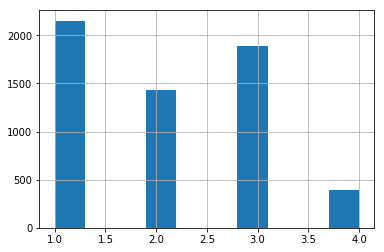

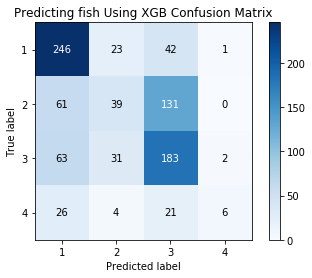

Predicting fish Using XGB Accuracy: 0.5392491467576792 Precision:0.5438379460331113 Recall:0.4296174609205169
Predicting fish Using XGB model's accuracy is 0.5558232931726909, with a standard deviation of 0.029997069796630627


In [120]:

bins = [0,0.1,0.2,0.5,1]
cleaned_our_bin_fish_df = construct_new_df(bins,cleaned_dhs_grouped_df,"Gave.child.fish.or.shellfish","fish_group")
run_tuned_xgboost(cleaned_our_bin_fish_df,"fish")

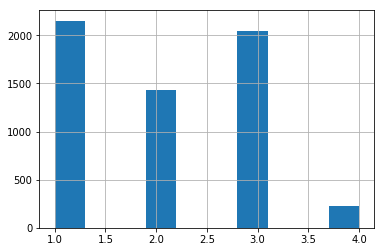

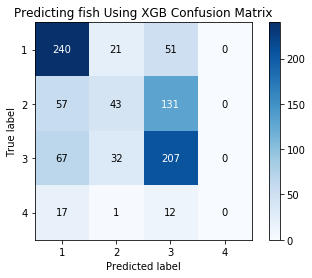

Predicting fish Using XGB Accuracy: 0.5574516496018203 Precision:0.3973574263059779 Recall:0.40796213590331243
Predicting fish Using XGB model's accuracy is 0.5710843373493976, with a standard deviation of 0.02613837766308911


In [92]:
bins = [0,0.1,0.2,0.5]
cleaned_our_bin_fish_df = construct_new_df(bins,cleaned_dhs_grouped_df,"Gave.child.fish.or.shellfish","fish_group")
run_tuned_xgboost(cleaned_our_bin_fish_df,"fish")

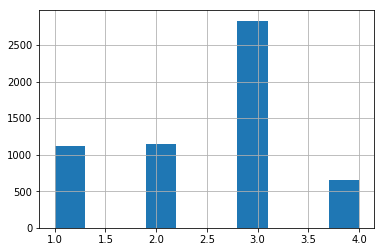

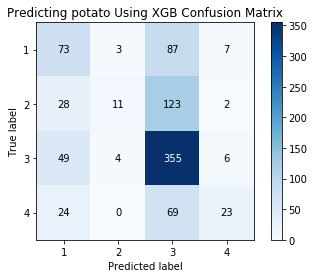

Predicting potato Using XGB Accuracy: 0.5347222222222222 Precision:0.5489628518520638 Recall:0.3880621800529673
Predicting potato Using XGB model's accuracy is 0.5336338216268102, with a standard deviation of 0.01994588111672485


In [93]:
bins = [0,0.1,0.2,0.5]
cleaned_our_bin_potato_df = construct_new_df(bins,cleaned_dhs_grouped_df,"Gave.child.potatoes..cassava..or.other.tubers","potato_group")
run_tuned_xgboost(cleaned_our_bin_potato_df,"potato")


### Regression Models 
* It's probably better to not use binned data here.

- Linear Regression
- Decision Tree Regression
- KNN Regression


In [98]:
from sklearn import neighbors
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error

In [111]:

dhs_reg_egg_df = dhs_ml_final_df[desired_cols + ["eggs"]]

def clean_reg_data(df):
    #   Making an assumption here that NA religion is no religion. 
    df["Primary_Religion"] = df["Primary_Religion"].fillna("No Religion")
    result_df = df.dropna()
    m = string_to_int(result_df, "Primary_Religion")
    result_df["Primary_Religion"] = result_df["Primary_Religion"].map(m)
    return result_df

In [112]:
dhs_reg_egg_cleaned_df = clean_reg_data(dhs_reg_egg_df)

In [113]:
def run_evaluate_regression(df):
    """
    This function takes an unbinned dataframe and runs regression using
    different regressors. It also evaluates different models using 
    """
    reg_models = [("decision tree" , DecisionTreeRegressor())]
    X_train, X_validate, Y_train, Y_validate = separate_training_testing(df)
#     model_evaluate(X_train, X_validate, Y_train, Y_validate, 10, len(X_train), 7, 'accuracy', models, out_come,False)
    for name, model in reg_models:
        cv_score = cross_val_score(model,X_train,Y_train,cv = 10)
        print("Accuracy: %0.2f (+/- %0.2f)" % (cv_score.mean(), cv_score.std() * 2))


In [114]:
run_evaluate_regression(dhs_reg_egg_cleaned_df)

Accuracy: -0.52 (+/- 0.35)


###  New Features
* Waiting for Mike to send it. 
1) Road Density https://datacatalog.worldbank.org/dataset/grip-global-roads-inventory-dataset-2018-road-density (Ask Mike for help)
2) Global Cropland and Field Size Still waiting on this resource
3) Add More Country Level Data 

In [94]:
new_df = pd.read_csv("datasets/DHS_Data_By_Cell_with_Regression_Dat_9August2019.csv")
new_predictor_cols = ["Road_distance","Urban_binary","Crop_binary","Irrigation_binary"]
new_partial_df = new_df[new_predictor_cols + ["Cell_Order"]]

In [95]:
new_feature_cleaned_dhs_grouped_df = cleaned_dhs_grouped_df.merge(new_partial_df, on="Cell_Order",how = "inner")

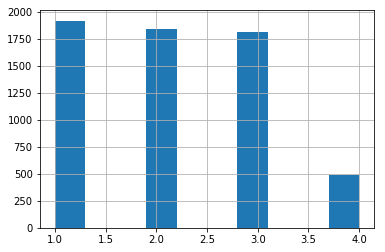

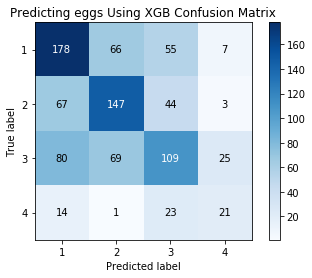

Predicting eggs Using XGB Accuracy: 0.5005500550055005 Precision:0.47284246178735534 Recall:0.47150223780009093
Predicting eggs Using XGB model's accuracy is 0.5101922932189359, with a standard deviation of 0.021107340312081155


In [96]:
new_cleaned_ml_egg_df = construct_new_df(bins,new_feature_cleaned_dhs_grouped_df,"eggs", "eggs_group")
run_tuned_xgboost(new_cleaned_ml_egg_df,"eggs")

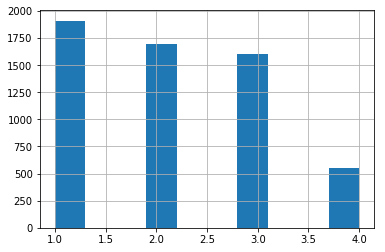

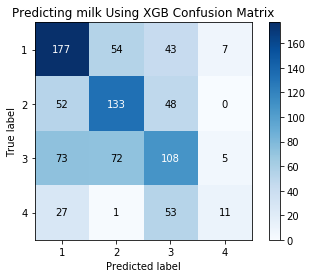

Predicting milk Using XGB Accuracy: 0.4965277777777778 Precision:0.48909117016193804 Recall:0.43471963940800895
Predicting milk Using XGB model's accuracy is 0.5344601644338717, with a standard deviation of 0.020219346350630264


In [97]:
new_cleaned_ml_milk_df = construct_new_df(bins,new_feature_cleaned_dhs_grouped_df,"Gave.child.tinned..powdered.or.fresh.milk", "milk_group")
run_tuned_xgboost(new_cleaned_ml_milk_df,"milk")

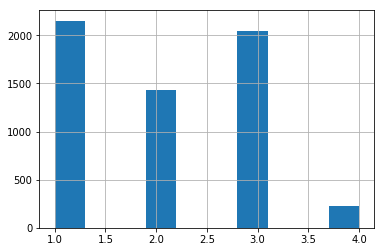

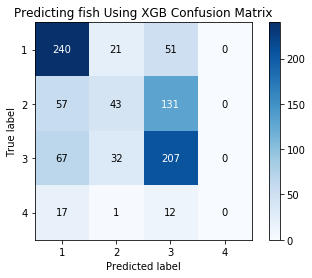

Predicting fish Using XGB Accuracy: 0.5574516496018203 Precision:0.3973574263059779 Recall:0.40796213590331243
Predicting fish Using XGB model's accuracy is 0.5710843373493976, with a standard deviation of 0.02613837766308911


In [115]:
new_cleaned_ml_fish_df = construct_new_df(bins,new_feature_cleaned_dhs_grouped_df,"Gave.child.fish.or.shellfish", "fish_group")
run_tuned_xgboost(new_cleaned_ml_fish_df,"fish")

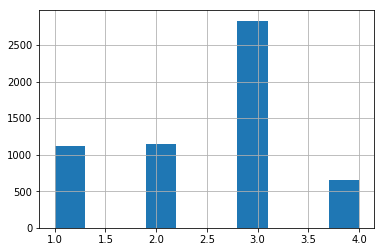

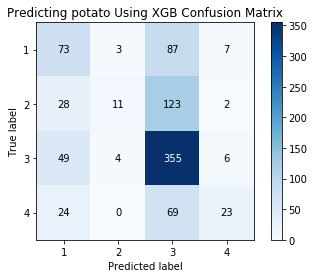

Predicting potato Using XGB Accuracy: 0.5347222222222222 Precision:0.5489628518520638 Recall:0.3880621800529673
Predicting potato Using XGB model's accuracy is 0.5336338216268102, with a standard deviation of 0.01994588111672485


In [116]:
p_bins = []
new_cleaned_ml_potatoes_df = construct_new_df(bins,new_feature_cleaned_dhs_grouped_df,"Gave.child.potatoes..cassava..or.other.tubers", "potato_group")
run_tuned_xgboost(new_cleaned_ml_potatoes_df,"potato")

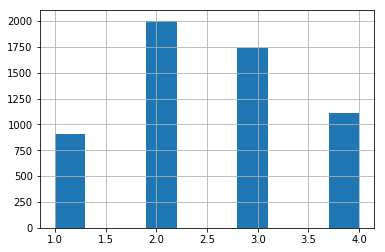

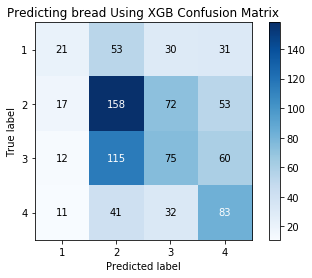

Predicting bread Using XGB Accuracy: 0.3900462962962963 Precision:0.37481761185365037 Recall:0.3663719380577268
Predicting bread Using XGB model's accuracy is 0.3917440841367222, with a standard deviation of 0.015756451693867985


In [127]:
bread_bins = [0,0.4,0.55,0.7]
new_cleaned_ml_bread_df = construct_new_df(bread_bins,new_feature_cleaned_dhs_grouped_df,"Gave.child.bread..noodles..other.made.from.grains", "bread_group")
run_tuned_xgboost(new_cleaned_ml_bread_df,"bread")

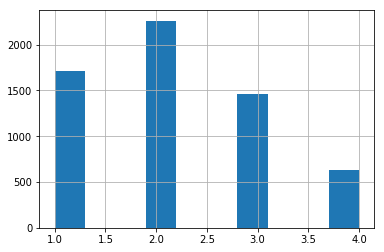

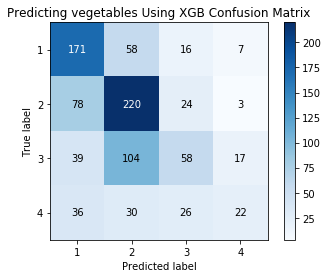

Predicting vegetables Using XGB Accuracy: 0.5181518151815182 Precision:0.49461997190566387 Recall:0.453633001876604
Predicting vegetables Using XGB model's accuracy is 0.5108737864077669, with a standard deviation of 0.01881492279107925


In [136]:
veg_bins = [0, 0.15,0.3,0.5]
new_cleaned_ml_veg_df = construct_new_df(veg_bins,new_feature_cleaned_dhs_grouped_df,"Gave.child.any.dark.green.leafy.vegetables", "vegetables_group")
run_tuned_xgboost(new_cleaned_ml_veg_df,"vegetables")

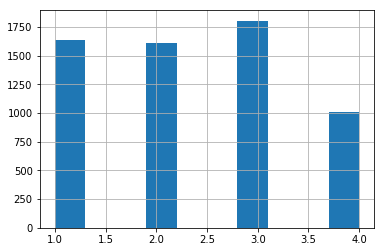

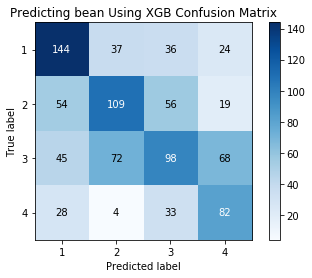

Predicting bean Using XGB Accuracy: 0.47634763476347636 Precision:0.47167216359336067 Recall:0.4899016121557929
Predicting bean Using XGB model's accuracy is 0.4941747572815534, with a standard deviation of 0.01679920281426015


In [137]:
new_cleaned_ml_bean_df = construct_new_df(bins,new_feature_cleaned_dhs_grouped_df,"Gave.child.food.made.from.beans..peas..lentils..nuts", "bean_group")
run_tuned_xgboost(new_cleaned_ml_bean_df,"bean")

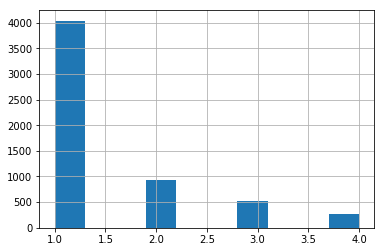

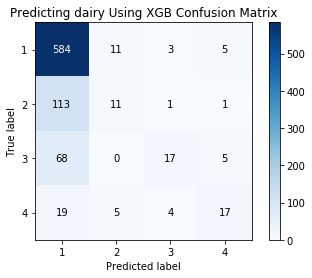

Predicting dairy Using XGB Accuracy: 0.7280092592592593 Precision:0.6098620559334845 Recall:0.4056147832267235
Predicting dairy Using XGB model's accuracy is 0.7170372688952883, with a standard deviation of 0.015619360896419895


In [138]:
new_cleaned_ml_dairy_df = construct_new_df(bins,new_feature_cleaned_dhs_grouped_df,"Gave.child.cheese..yogurt..other.milk.products", "dairy_product_group")
run_tuned_xgboost(new_cleaned_ml_dairy_df,"dairy")

Performance dropped after adding new data for milk. 

Todo list for this week.
* 1&2 from Mike 

1)Regression. Not ideal. Gave up. 

2) Similar to 2: what if we were to use a binomial model on the household data to predict consumption vs not consumption? We could then use the % estimates from the binomial outcome (i.e. not which bin the household is most likely to be in, but rather the % likelihood that a household reported consumption for the food group) as an estimate of consumption at the cell level. We could even estimate an RMSE-like equivalent where: actual value = average consumption at the cell, predicted value = % probability from the binomial model when applied to the cell.(SIDE PROJECT)

3) Switch the data usage to DHS Data by Cell with Regression DAT_24jUNE 2019.(DONE)
4) Fine Tune XGBoost Model(DONE)

5) ADD new features. (Mike sent!)(DONE)

In [122]:
x = np.array([0.2, 6.4, 3.0, 1.6])
b = np.array([0.0, 1.0, 2.5, 4.0])
inds = np.digitize(x, b)
inds

array([1, 4, 3, 2], dtype=int64)